In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Integer

columns = [
    'Stages', '_Lr1', '_Hr1',
    '_Lr2', '_Hr2', '_T_hex',
    '_Lr3', '_Hr3',
    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', 'Shortcut_Time',
    'Rigorous_CAPEX', 'Rigorous_OPEX', 'Rigorous_AceticAcidWt', 'Rigorous_Time'
]

# Create dataframe
results=pd.read_csv("/users/k23070952/MultiFidelity-ProcessOpt/3. Data/results_250327.csv")
results_df = pd.DataFrame(results.values, columns=columns)
results_df



,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36219,32.398155,0.868058,0.322978,0.927797,0.144258,299.868209,0.194531,0.795025,1.3530,0.9891,...,8.0,6.0,0.261309,4.0,1.0,0.472213,1.6911,1.0430,0.979106,21.103383
36220,13.079315,0.718414,0.241063,0.748787,0.495020,306.423068,0.205159,0.041450,1.9673,24.1184,...,9.0,8.0,16.871607,-3.0,0.0,2.904197,2.5598,31.7062,0.021241,22.271592
36221,22.934463,0.413409,0.487228,0.942244,0.372015,336.109595,0.806054,0.968923,1.4943,0.6078,...,14.0,11.0,0.048232,12.0,2.0,0.957504,1.3704,0.6035,0.884685,113.890179
36222,3.021279,0.923848,0.801444,0.577782,0.849504,294.118951,0.236731,0.660374,1.5452,1.2941,...,8.0,7.0,0.516968,4.0,1.0,0.364881,1.4648,1.3370,0.269399,17.051245


In [8]:
len(columns)

26

In [2]:
# 목적함수 관련 열 지정
capex_col = 'Rigorous_CAPEX'
opex_col = 'Rigorous_OPEX'
purity_col = 'Rigorous_AceticAcidWt'

# 조건: Acetic acid purity ≥ 0.98
filtered_df = results_df[results_df[purity_col] >= 0.98].copy()

# 결측값 제거 (혹시 몰라 안전하게)
filtered_df = filtered_df.dropna(subset=[capex_col, opex_col])

# 최적화 목적함수 계산: CAPEX + OPEX
filtered_df['Objective'] = filtered_df[capex_col] + filtered_df[opex_col]

# (1) Empirical 최적값
empirical_best = filtered_df['Objective'].min()

# (2) 상위 10% 기준값 (최소화 문제 → 하위 10%)
top_10_percentile = np.percentile(filtered_df['Objective'], 10)

# 결과 확인
print(f"💡 Empirical 최적값 (CAPEX + OPEX): {empirical_best:.2f}")
print(f"🎯 상위 10% 경계값 (Objective ≤ 이 값이면 성공으로 간주): {top_10_percentile:.2f}")
print(f"✅ 조건을 만족하는 시뮬레이션 수: {len(filtered_df)} / 전체 {len(results_df)}개")


💡 Empirical 최적값 (CAPEX + OPEX): 1.09
🎯 상위 10% 경계값 (Objective ≤ 이 값이면 성공으로 간주): 2.27
✅ 조건을 만족하는 시뮬레이션 수: 1993 / 전체 36224개


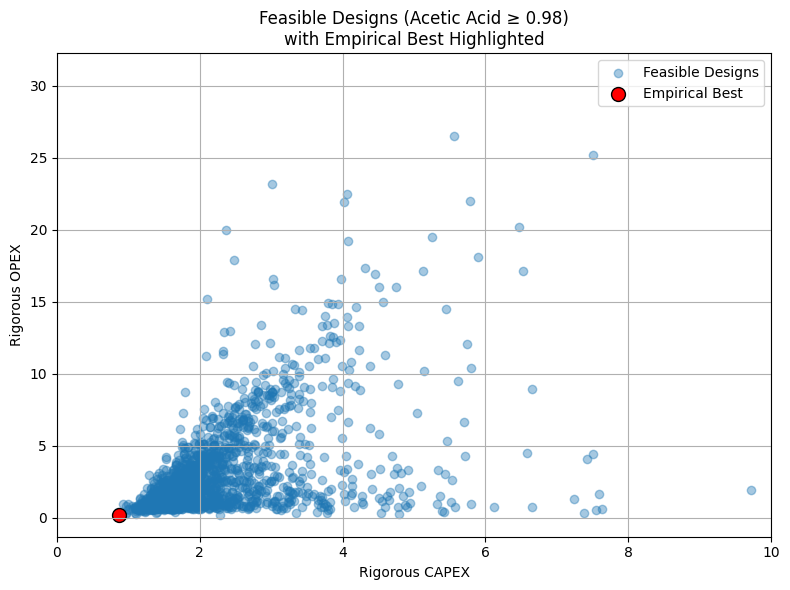

In [5]:
import matplotlib.pyplot as plt

# 최적값 찾기 (index 기준)
best_idx = filtered_df['Objective'].idxmin()
best_point = filtered_df.loc[best_idx]

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['Rigorous_CAPEX'], filtered_df['Rigorous_OPEX'], alpha=0.4, label='Feasible Designs')
plt.scatter(best_point['Rigorous_CAPEX'], best_point['Rigorous_OPEX'],
            color='red', label='Empirical Best', s=100, edgecolors='black')

plt.xlabel('Rigorous CAPEX')
plt.ylabel('Rigorous OPEX')
plt.title('Feasible Designs (Acetic Acid ≥ 0.98)\nwith Empirical Best Highlighted')
plt.xlim(0, 10)  # CAPEX 범위 고정
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# 최적값이 있는 행 출력
best_row = filtered_df.loc[best_idx]
pd.set_option('display.max_columns', None)  # 모든 열 보기 위해 설정
print("📌 Empirical 최적값에 해당하는 변수들:")
print(best_row)

📌 Empirical 최적값에 해당하는 변수들:
Stages                      29.027381
_Lr1                         0.525691
_Hr1                         0.230975
_Lr2                         0.967419
_Hr2                         0.502674
_T_hex                     325.670731
_Lr3                         0.007841
_Hr3                         0.950699
Shortcut_CAPEX               1.311200
Shortcut_OPEX                0.606200
Shortcut_AceticAcidWt        0.315431
Shortcut_SplitRatio          0.013807
Shortcut_BoilupRatio_1       1.475917
Shortcut_NumberStages_1      2.000000
Shortcut_FeedStage_1         2.000000
Shortcut_BoilupRatio_2      21.990208
Shortcut_NumberStages_2     18.000000
Shortcut_FeedStage_2        15.000000
Shortcut_BoilupRatio_3       0.051539
Shortcut_NumberStages_3      2.000000
Shortcut_FeedStage_3         1.000000
Shortcut_Time                1.164644
Rigorous_CAPEX               0.871300
Rigorous_OPEX                0.222500
Rigorous_AceticAcidWt        0.984070
Rigorous_Time          